In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples



In [ ]:
# Load the Dataset
data = pd.read_csv('shopping_trends.csv')

# Step 1: Data Preprocessing

for col in data.select_dtypes(include=['object']).columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Encoding
categorical_columns = ['Gender', 'Category', 'Location', 'Size', 'Color', 'Season',
                       'Subscription Status', 'Payment Method', 'Shipping Type',
                       'Discount Applied', 'Promo Code Used', 'Preferred Payment Method',
                       'Frequency of Purchases']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Standardisation
numerical_features = ['Age', 'Purchase Amount (USD)', 'Previous Purchases', 'Review Rating']
scaler = StandardScaler()
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])


<ipython-input-53-3d009eac2a7e>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


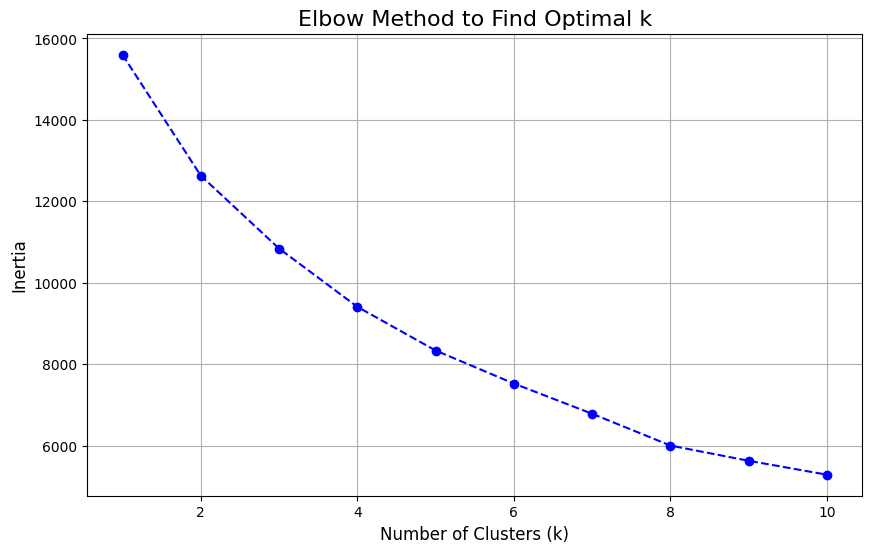

In [ ]:

# Step 2: Determine Optimal Number of Clusters
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_encoded[numerical_features])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method to Find Optimal k', fontsize=16)
plt.grid(True)
plt.show()

In [ ]:
# Step 3: Apply K-Means Clustering with Optimal k
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_encoded['Cluster'] = kmeans.fit_predict(data_encoded[numerical_features])
data['Cluster'] = data_encoded['Cluster']

         Customer ID        Age  Purchase Amount (USD)  Review Rating  \
Cluster                                                                 
0        1948.730104  57.247405              77.523356       3.853806   
1        1946.417158  45.911591              35.838245       3.629011   
2        1957.304026  29.237469              72.916187       3.803040   

         Previous Purchases  Cluster  
Cluster                               
0                 27.359862      0.0  
1                 25.631958      1.0  
2                 23.092030      2.0  


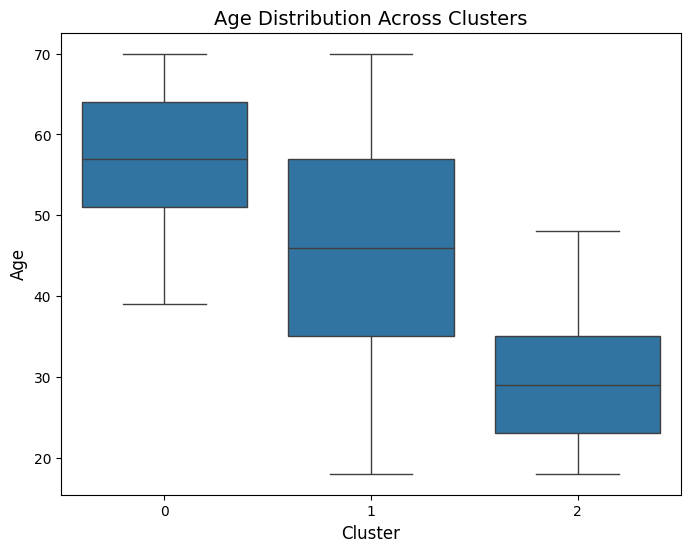

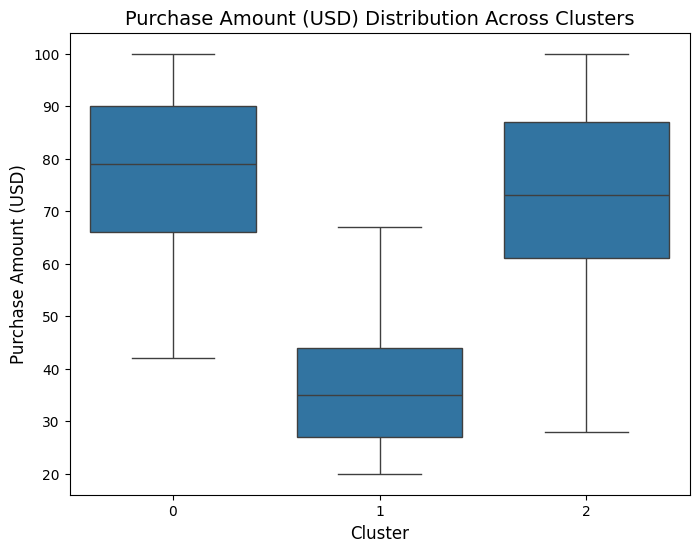

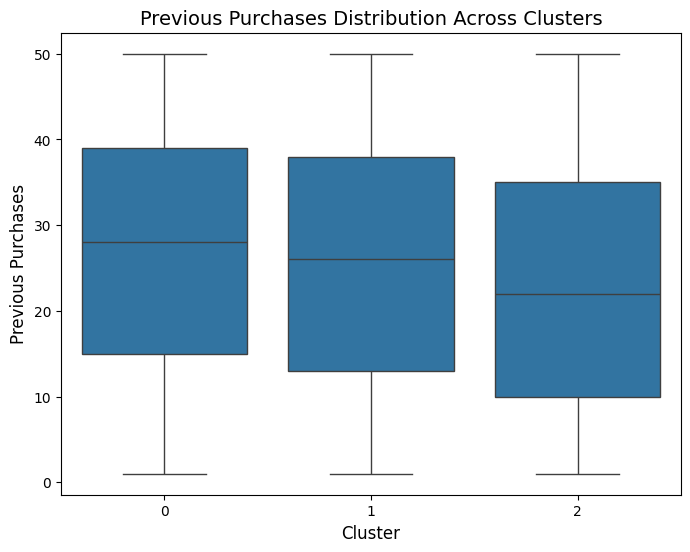

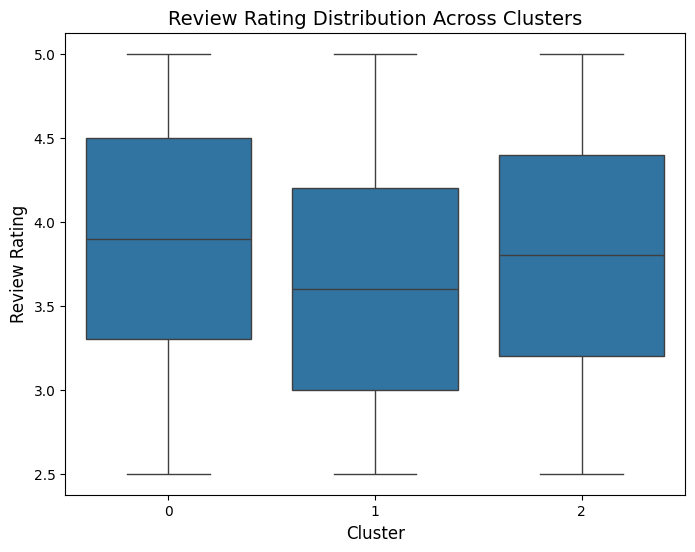

In [ ]:
# Step 4: Analyze Clusters

numerical_columns = data.select_dtypes(include=np.number).columns
cluster_summary = data.groupby('Cluster')[numerical_columns].mean()
print(cluster_summary)

# Boxplot for Numerical Features
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Cluster', y=feature, data=data)
    plt.title(f'{feature} Distribution Across Clusters', fontsize=14)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.show()


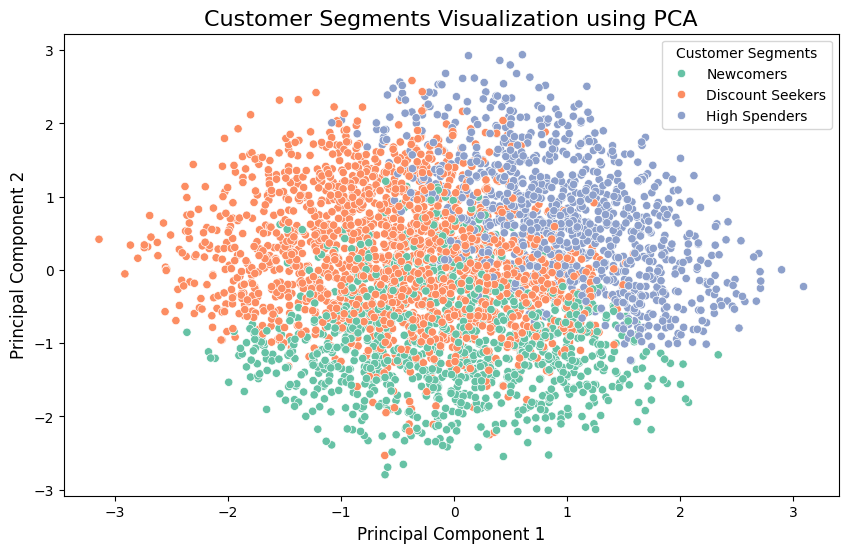

In [ ]:
# Perform PCA for Dimensionality Reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_encoded[numerical_features])
data_encoded['PCA1'] = principal_components[:, 0]
data_encoded['PCA2'] = principal_components[:, 1]

# Map Clusters to Descriptive Labels
# Example: Replace the cluster numbers with meaningful labels
# Perform cluster analysis first to decide these mappings
cluster_labels = {
    0: 'Discount Seekers',  # Example label for cluster 0
    1: 'High Spenders',     # Example label for cluster 1
    2: 'Newcomers'          # Example label for cluster 2
}

# Add Cluster Labels to Data
data_encoded['Cluster Label'] = data_encoded['Cluster'].map(cluster_labels)

# Plot with Descriptive Labels
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster Label',
    data=data_encoded,
    palette='Set2',
    legend="full"
)
plt.title('Customer Segments Visualization using PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Customer Segments')
plt.show()


Silhouette Score for the clustering is: 0.17599091873114467


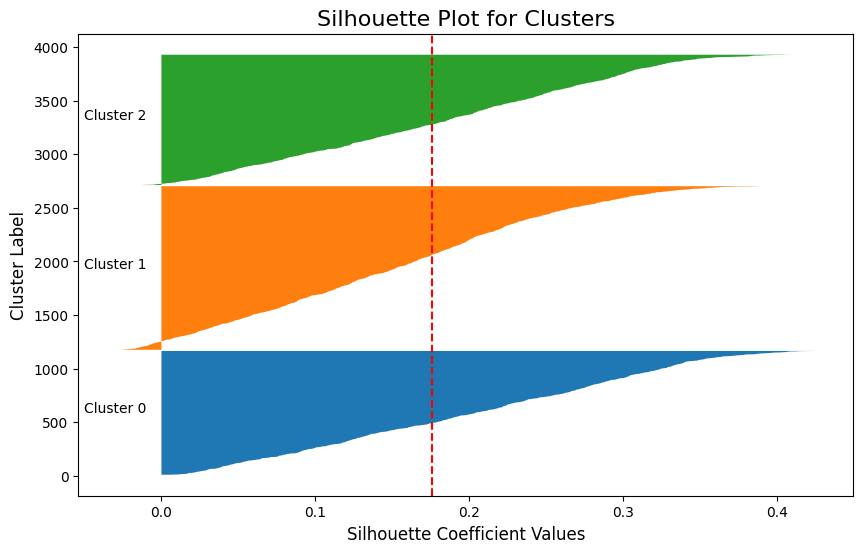

In [ ]:
# Step 6: Evaluate Clustering Performance using Silhouette Score
silhouette_avg = silhouette_score(data_encoded[numerical_features], data_encoded['Cluster'])
print(f'Silhouette Score for the clustering is: {silhouette_avg}')

# Silhouette Plot
silhouette_values = silhouette_samples(data_encoded[numerical_features], data_encoded['Cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(optimal_k):
    ith_silhouette_values = silhouette_values[data_encoded['Cluster'] == i]
    ith_silhouette_values.sort()
    y_upper = y_lower + len(ith_silhouette_values)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * len(ith_silhouette_values), f"Cluster {i}")
    y_lower = y_upper + 10
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette Plot for Clusters", fontsize=16)
plt.xlabel("Silhouette Coefficient Values", fontsize=12)
plt.ylabel("Cluster Label", fontsize=12)
plt.show()

Silhouette Score for Agglomerative Clustering with K-Means Features: 0.12753149101388708


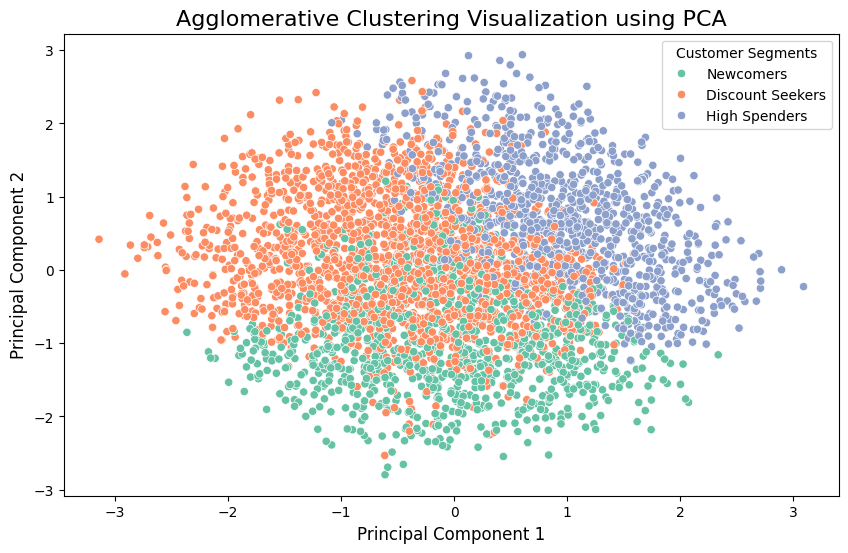

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Select Features for Clustering
selected_features = ['Age', 'Purchase Amount (USD)', 'Previous Purchases', 'Review Rating']
data_selected = data_encoded[selected_features]

# Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=3, linkage='ward')
data_encoded['Cluster'] = agglo.fit_predict(data_selected)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(data_selected, data_encoded['Cluster'])
print(f"Silhouette Score for Agglomerative Clustering with K-Means Features: {silhouette_avg}")

# Map Clusters to Descriptive Labels (Example Labels)
# Replace with the appropriate labels based on your cluster summary
cluster_labels = {
    0: 'Discount Seekers',
    1: 'High Spenders',
    2: 'Newcomers'
}

# Add Cluster Labels to Data
data_encoded['Cluster Label'] = data_encoded['Cluster'].map(cluster_labels)

# Perform PCA for Visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_selected)
data_encoded['PCA1'] = principal_components[:, 0]
data_encoded['PCA2'] = principal_components[:, 1]

# Visualization with Descriptive Labels
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster Label',
    data=data_encoded,
    palette='Set2',
    legend="full"
)
plt.title('Agglomerative Clustering Visualization using PCA', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Customer Segments')
plt.show()
